# Human monitoring activity

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import classification_report,confusion_matrix


# # Read data & add to X, y

In [31]:
def load_files(filepath):
    dataset = pd.DataFrame()
    #y = 
    for i in range(1, 15):
        filename1 = filepath + str(i) + '.csv'
        # I need class as a column to be able to do a pairplot
        dataset_trainX = pd.read_csv(filename1, usecols=[1,2,3,4], names=['ax', 'ay', 'az', 'class'], header=None)
        dataset = dataset.append(dataset_trainX, ignore_index = True)
        #position_class

    return dataset

In [32]:
filepath = 'activityRecognition/'
dataset = load_files(filepath)

In [33]:
dataset = dataset[dataset['class'] != 0] # tar bort alla med klass 0

# Remove outliners

In [34]:
# reomve ouliners # ta bort alla extrema värden!

#ay
max_thresold = dataset["ay"].quantile(0.99997) #0.999985  lägre mindre distru

min_thresold = dataset["ay"].quantile(0.000015)  # högre mindre dis -1->5---jag har nu lag högre

#az
az_max_thresold = dataset["az"].quantile(0.999982) #0.999985  lägre mindre dis

az_min_thresold = dataset["az"].quantile(0.00004)  # högre mindre distru -1->5---jag har nu lag högre

ax_min_thresold = dataset["ax"].quantile(0.00002)  # högre mindre distru -1->5---jag har nu lag högre
#X = X[(X["ay"]<max_thresold) & (X["ay"]>min_thresold)]
#X.plot()

dataset_noEx = pd.DataFrame()

dataset_noEx = dataset[(dataset["ay"]<max_thresold) & (dataset["ay"]>min_thresold) & (dataset["az"]<az_max_thresold) & (dataset["az"]>az_min_thresold)  & (dataset["ax"]>ax_min_thresold)]

# Balance data

In [35]:
dataset["class"].value_counts()

7    576063
1    557067
4    339554
3    208827
5     48198
6     46770
2     43198
Name: class, dtype: int64

In [36]:
one = dataset[dataset['class'] == 1].head(43198).copy()
two = dataset[dataset['class'] == 2].head(43198).copy()
three = dataset[dataset["class"]==3].head(43198).copy()
four = dataset[dataset["class"]==4].head(43198).copy()
five = dataset[dataset["class"]==5].head(43198).copy()
six = dataset[dataset["class"]==6].head(43198).copy()
seven = dataset[dataset["class"]==7].head(43198).copy()


balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([one, two, three, four, five, six, seven])
balanced_data.shape


(302386, 4)

In [37]:
balanced_data["class"].value_counts()

1    43198
2    43198
3    43198
4    43198
5    43198
6    43198
7    43198
Name: class, dtype: int64

In [38]:
balanced_data.head()

,ax,ay,az,class
0,1502,2215,2153,1
1,1667,2072,2047,1
2,1611,1957,1906,1
3,1601,1939,1831,1
4,1643,1965,1879,1


# Split data

In [39]:
X = balanced_data[['ax', 'ay', 'az']]
y = balanced_data['class']

# Standard scalar

In [40]:
sc=StandardScaler()
X = sc.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns= ['ax', 'ay', 'az'])
scaled_X['class'] = y.values

scaled_X

,ax,ay,az,class
0,-4.360582,-1.897328,1.715083,1
1,-2.864340,-3.680314,0.580267,1
2,-3.372156,-5.114184,-0.929253,1
3,-3.462837,-5.338616,-1.732190,1
4,-3.081976,-5.014437,-1.218311,1
...,...,...,...,...
302381,-0.824011,0.534017,0.762266,7
302382,-0.733329,0.770917,0.708736,7
302383,-0.805874,0.745980,0.494620,7
302384,-0.905624,0.396864,0.216269,7


# Frame preparation

In [41]:
import scipy.stats as stats

In [42]:
fs = 52
frame_size = fs*1 #52 samples
hop_size = fs*2 #40

In [43]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['ax'].values[i: i + frame_size]
        y = df['ay'].values[i: i + frame_size]
        z = df['az'].values[i: i + frame_size]
               
        #retrive the most often used label in this segment
        label = stats.mode(df['class'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)
            
    #bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
                              
    return frames, labels

In [44]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [45]:
X.shape, y.shape

((2908, 52, 3), (2908,))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [47]:
X_train.shape, X_test.shape

((2326, 52, 3), (582, 52, 3))

In [48]:
X_train[0].shape, X_train[0].shape

((52, 3), (52, 3))

In [49]:
X_train = X_train.reshape(2326, 52, 3, 1)
X_test = X_test.reshape(582, 52, 3, 1)

In [50]:
X_train[0].shape, X_train[0].shape

((52, 3, 1), (52, 3, 1))

# 2D CNN Model

In [51]:
model = Sequential()
model.add(Conv2D(16, (2,2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))

In [52]:
model.compile(optimizer=Adam(learning_rate= 0.001), loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [53]:
history = model.fit(X_train, y_train, epochs=10, validation_data = (X_test, y_test), verbose=1, use_multiprocessing = True)

Train on 2326 samples, validate on 582 samples
Epoch 1/10
2326/2326 [==============================] - 1s 392us/sample - loss: 1.6686 - accuracy: 0.4226 - val_loss: 1.2033 - val_accuracy: 0.5756
Epoch 2/10
2326/2326 [==============================] - 0s 136us/sample - loss: 1.2275 - accuracy: 0.5757 - val_loss: 1.0234 - val_accuracy: 0.6546
Epoch 3/10
2326/2326 [==============================] - 0s 122us/sample - loss: 1.1075 - accuracy: 0.6131 - val_loss: 0.9289 - val_accuracy: 0.6770
Epoch 4/10
2326/2326 [==============================] - 0s 130us/sample - loss: 1.0159 - accuracy: 0.6414 - val_loss: 0.8964 - val_accuracy: 0.6890
Epoch 5/10
2326/2326 [==============================] - 0s 132us/sample - loss: 1.0042 - accuracy: 0.6496 - val_loss: 0.8549 - val_accuracy: 0.7045
Epoch 6/10
2326/2326 [==============================] - 0s 122us/sample - loss: 0.9246 - accuracy: 0.6763 - val_loss: 0.8410 - val_accuracy: 0.6959
Epoch 7/10
2326/2326 [==============================] - 0s 119us/

# Learning curve

In [54]:
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    #plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    

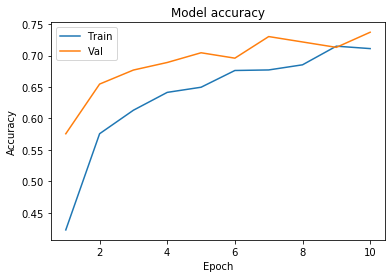

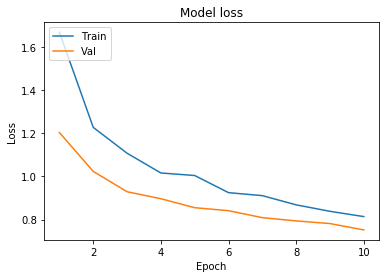

In [55]:
plot_learningCurve(history, 10)

# Confusion matrix

In [56]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x231506869c8>)

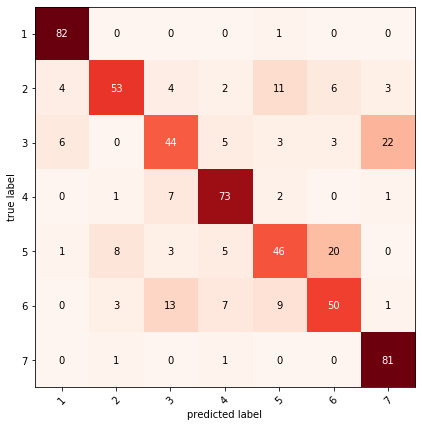

In [57]:
y_pred = model.predict_classes(X_test)

mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=['1', '2', '3', '4', '5', 
                                                '6', '7'], show_normed=False, figsize=(7,7), cmap=plt.cm.Reds)

In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
labels = ["1", "2", "3", "4", "5", "6", "7"]
cm = confusion_matrix(y_test, y_pred)
#print(cm, "CM")
#print(pd.Dataframe(cm))
# Accuracy
from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_pred) , "AC")
# Recall
from sklearn.metrics import recall_score
#print(recall_score(y_test, y_pred, average=None), "RE")
# Precision
from sklearn.metrics import precision_score
#print(precision_score(y_test, y_pred, average=None) , "PR")

# info 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.99      0.93        83
           2       0.80      0.64      0.71        83
           3       0.62      0.53      0.57        83
           4       0.78      0.87      0.82        84
           5       0.64      0.55      0.59        83
           6       0.63      0.60      0.62        83
           7       0.75      0.98      0.85        83

    accuracy                           0.74       582
   macro avg       0.73      0.74      0.73       582
weighted avg       0.73      0.74      0.73       582

